In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df=pd.read_csv("./bike_train.csv")
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
bike_df['datetime']=bike_df['datetime'].apply(pd.to_datetime)
bike_df['year']=bike_df.datetime.apply(lambda x : x.year)
bike_df['month']=bike_df.datetime.apply(lambda x : x.month)
bike_df['day']=bike_df.datetime.apply(lambda x : x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)
#casual+registered=datetime

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val=rmsle(y, pred)
    rmse_val=rmse(y, pred)
    mae_val=mean_absolute_error(y, pred)
    print("RMSLE : {0:.3F}, RMSE : {1:.3F}, MAE : {2:.3F}".format(rmsle_val, rmse_val, mae_val))


In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test, pred)
#rmsle는 로그를 취해서 작기도 하고, count 큰 것들에 대한 오류가 많으면 보통 이렇게 나온다(rmsle<<<rmse)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


In [14]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


In [15]:
##준내 다르자나! 이러면 타겟 값의 분포가 왜곡되었는지 확인해야함. 정규분포가 좋음


<AxesSubplot:>

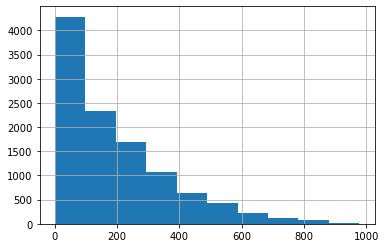

In [16]:
y_target.hist()

In [17]:
#왜곡 바꾸기-> 로그 이용

<AxesSubplot:>

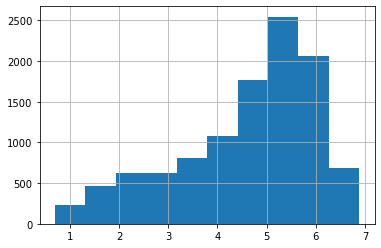

In [32]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [20]:
y_target_log=np.log1p(y_target)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

y_test_exp=np.expm1(y_test)#로그로 변환한거 다시 원래 값으로 스케일링

pred_exp=np.expm1(pred)#로그로 변환한거 다시 원래 값으로 스케일링



evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


In [21]:
#rmse오히려 늘어남-> count가 다른 것들이 더더더 벌어졌다는 의미

<AxesSubplot:>

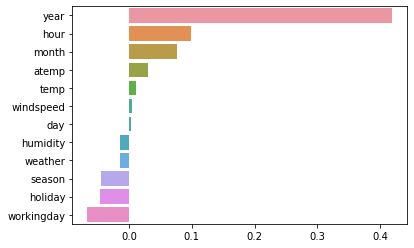

In [22]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [23]:
#선형 회귀는 무무무족권 must must 원핫 인코딩을 해야함.

In [26]:
X_features_ohe=pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [27]:
X_train, X_test, y_train, y_test=train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)


def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)


lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)


### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


<AxesSubplot:>

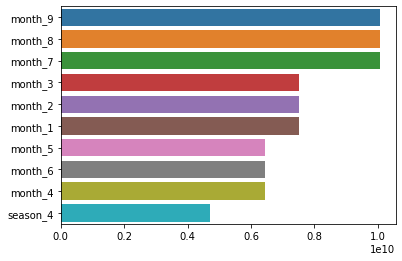

In [33]:
coef=pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
lgbm_reg=LGBMRegressor(n_estimators=500)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg ]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.420, MAE : 31.167
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.342, MAE : 32.747
### XGBRegressor ###
RMSLE : 0.342, RMSE : 51.732, MAE : 31.251
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029
